In [1]:
# ---------- Imports & Notebook Setup ----------
import re
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 6)
plt.rcParams["axes.grid"] = True

In [2]:
income_table = pd.read_csv(
    "data/TaxableIndividualsbyAssessedIncomeGroup.csv"
)
tax_residents = income_table[income_table['resident_type'] == 'Tax Resident']
non_tax_residents = income_table[income_table['resident_type'] == 'Non-Tax Resident']

In [3]:
# ---------- 0) Select Tax Residents ----------
df = income_table.copy()
df = df[df["resident_type"] == "Tax Resident"].copy()

# Safety: coerce numbers
num_cols = ["number_of_taxpayers", "assessable_income", "chargeable_income", "net_tax_assessed"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- 1) Parse & Order Income Bins ----------
# Expected examples:
# "20,000 & below", "20,001 - 25,000", ..., "1,000,001 & above"
def parse_bin_bounds(label: str):
    s = label.replace(",", "").strip()
    # "& below"
    m = re.match(r"^(\d+)\s*&\s*below$", s, flags=re.I)
    if m:
        upper = int(m.group(1))
        lower = 0
        return lower, upper, True, False  # closed on upper (<= upper)
    # "& above"
    m = re.match(r"^(\d+)\s*&\s*above$", s, flags=re.I)
    if m:
        lower = int(m.group(1))
        upper = math.inf
        return lower, upper, False, True
    # "a - b"
    m = re.match(r"^(\d+)\s*-\s*(\d+)$", s)
    if m:
        lower = int(m.group(1))
        upper = int(m.group(2))
        return lower, upper, False, False
    raise ValueError(f"Unrecognized bin label: {label!r}")

# Extract bin bounds and order
bins_meta = (
    df["assessed_income_group"]
    .dropna()
    .unique()
)
bin_info = []
for lbl in bins_meta:
    lo, hi, is_below, is_above = parse_bin_bounds(lbl)
    bin_info.append((lbl, lo, hi, is_below, is_above))
bin_info = sorted(bin_info, key=lambda x: (x[1], float("inf") if x[2] == math.inf else x[2]))

# Create ordered categorical for plotting
ordered_labels = [x[0] for x in bin_info]
df["assessed_income_group"] = pd.Categorical(df["assessed_income_group"], categories=ordered_labels, ordered=True)

# For stats from binned data, we need representative points per bin (midpoints);
# For open-ended top bin, assume mean ~ 1.25 * lower bound (adjustable).
def representative_value(lo, hi, top_tail_factor=1.25):
    if hi == math.inf:
        return lo * top_tail_factor
    return (lo + hi) / 2.0

rep_values = {}
for lbl, lo, hi, *_ in bin_info:
    rep_values[lbl] = representative_value(lo, hi)

# ---------- 2) Build Per-Year Distributions ----------
# Sum taxpayers across the same year/bin if duplicated rows exist.
dist = (
    df.groupby(["year_of_assessment", "assessed_income_group"], observed=True)["number_of_taxpayers"]
      .sum()
      .reset_index()
)

# Normalize to shares within each year
dist["share_of_taxpayers"] = dist.groupby("year_of_assessment")["number_of_taxpayers"].transform(
    lambda x: x / x.sum()
)

# ---------- 3) Descriptive Statistics per Year (from binned data) ----------
def binned_stats_one_year(dsub: pd.DataFrame):
    # dsub has columns: assessed_income_group, number_of_taxpayers, share_of_taxpayers
    dsub = dsub.sort_values("assessed_income_group")
    # Representative income per bin
    vals = dsub["assessed_income_group"].map(rep_values).astype(float).values
    weights = dsub["share_of_taxpayers"].values
    # Estimated mean
    mean_est = np.sum(vals * weights)
    # Estimated median (p=0.5) via cumulative weights (linear within-bin assumption)
    cdf = np.cumsum(weights)
    # Find first bin where CDF >= 0.5
    idx = np.searchsorted(cdf, 0.5)
    if idx == 0:
        median_est = vals[0]
    else:
        # interpolate between previous and current rep point by weight proportions
        prev_cdf = cdf[idx - 1] if idx > 0 else 0.0
        bin_w = weights[idx]
        if bin_w == 0:
            median_est = vals[idx]
        else:
            frac = (0.5 - prev_cdf) / bin_w
            # simple interpolation to next rep point (crude; bins are not continuous points)
            # For a better estimate, use bin lower/upper bounds:
            lbl = dsub["assessed_income_group"].iloc[idx]
            lo, hi, *_ = next((lo, hi, b, a) for lab, lo, hi, b, a in bin_info if lab == lbl)
            if hi == math.inf:
                hi = representative_value(lo, hi)  # fallback
            median_est = lo + frac * (hi - lo)

    # Estimated Gini from grouped data using trapezoidal Lorenz approximation
    # Steps:
    # 1) build (cum_pop, cum_income) using bin means and weights
    # 2) gini = 1 - 2 * area_under_lorenz
    incomes = vals
    pop_shares = weights
    income_shares = incomes * pop_shares
    income_shares = income_shares / income_shares.sum()

    cum_pop = np.concatenate([[0], np.cumsum(pop_shares)])
    cum_inc = np.concatenate([[0], np.cumsum(income_shares)])

    # trapezoid area
    area = np.trapz(cum_inc, cum_pop)
    gini_est = 1 - 2 * area

    # Some convenient buckets
    # Share earning <= 50k
    bins_le_50k = [lbl for lbl, lo, hi, *_ in bin_info if (hi != math.inf and hi <= 50000)]
    share_le_50k = dsub.loc[dsub["assessed_income_group"].isin(bins_le_50k), "share_of_taxpayers"].sum()

    # Share earning >= 100k
    bins_ge_100k = [lbl for lbl, lo, hi, *_ in bin_info if (lo >= 100000)]
    share_ge_100k = dsub.loc[dsub["assessed_income_group"].isin(bins_ge_100k), "share_of_taxpayers"].sum()

    return pd.Series({
        "mean_income_est": mean_est,
        "median_income_est": median_est,
        "gini_est": gini_est,
        "share_<=50k": share_le_50k,
        "share_>=100k": share_ge_100k
    })

stats_by_year = (
    dist.groupby("year_of_assessment")
        .apply(binned_stats_one_year)
        .reset_index()
        .sort_values("year_of_assessment")
)

display(stats_by_year.style.format({
    "mean_income_est": "S$ {:,.0f}",
    "median_income_est": "S$ {:,.0f}",
    "gini_est": "{:.3f}",
    "share_<=50k": "{:.1%}",
    "share_>=100k": "{:.1%}",
}))

# Print some quick textual insights
if not stats_by_year.empty:
    first_year = stats_by_year["year_of_assessment"].min()
    last_year = stats_by_year["year_of_assessment"].max()
    s0 = stats_by_year.loc[stats_by_year["year_of_assessment"] == first_year].iloc[0]
    s1 = stats_by_year.loc[stats_by_year["year_of_assessment"] == last_year].iloc[0]
    print(f"\nKey changes from {first_year} to {last_year}:")
    print(f"- Estimated mean income: S$ {s0['mean_income_est']:,.0f} → S$ {s1['mean_income_est']:,.0f}")
    print(f"- Estimated median income: S$ {s0['median_income_est']:,.0f} → S$ {s1['median_income_est']:,.0f}")
    print(f"- Estimated Gini (from binned data): {s0['gini_est']:.3f} → {s1['gini_est']:.3f}")
    print(f"- Share earning ≤ 50k: {s0['share_<=50k']:.1%} → {s1['share_<=50k']:.1%}")
    print(f"- Share earning ≥ 100k: {s0['share_>=100k']:.1%} → {s1['share_>=100k']:.1%}")

,year_of_assessment,mean_income_est,median_income_est,gini_est,share_<=50k,share_>=100k
0,2004,"S$ 76,198","S$ 48,446",0.424,52.7%,16.3%
1,2005,"S$ 78,182","S$ 49,115",0.428,51.5%,16.9%
2,2006,"S$ 80,744","S$ 49,859",0.438,50.2%,17.8%
3,2007,"S$ 83,179","S$ 50,779",0.445,49.1%,18.6%
4,2008,"S$ 87,198","S$ 52,343",0.457,47.4%,20.1%
5,2009,"S$ 88,114","S$ 53,394",0.457,46.2%,21.0%
6,2010,"S$ 86,196","S$ 52,293",0.454,47.5%,20.7%
7,2011,"S$ 87,831","S$ 52,835",0.460,47.0%,21.3%
8,2012,"S$ 88,487","S$ 53,029",0.463,46.8%,21.8%
9,2013,"S$ 87,882","S$ 52,867",0.461,47.0%,21.7%



Key changes from 2004 to 2023:
- Estimated mean income: S$ 76,198 → S$ 104,986
- Estimated median income: S$ 48,446 → S$ 63,632
- Estimated Gini (from binned data): 0.424 → 0.466
- Share earning ≤ 50k: 52.7% → 37.4%
- Share earning ≥ 100k: 16.3% → 29.9%


In [4]:
# --- 1) Filter to Tax Residents
df = income_table.copy()
df = df[df["resident_type"] == "Tax Resident"].copy()

# Ensure numeric
for c in ["number_of_taxpayers", "assessable_income", "chargeable_income", "net_tax_assessed"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- 2) Parse and order income bins
# Supported examples:
# "20,000 & below", "20,001 - 25,000", ..., "1,000,001 & above"
def parse_bin_bounds(label: str):
    s = label.replace(",", "").strip()
    m = re.match(r"^(\d+)\s*&\s*below$", s, flags=re.I)
    if m:
        upper = int(m.group(1))
        lower = 0
        return lower, upper, True, False  # (lo, hi, is_below, is_above)
    m = re.match(r"^(\d+)\s*&\s*above$", s, flags=re.I)
    if m:
        lower = int(m.group(1))
        upper = math.inf
        return lower, upper, False, True
    m = re.match(r"^(\d+)\s*-\s*(\d+)$", s)
    if m:
        return int(m.group(1)), int(m.group(2)), False, False
    raise ValueError(f"Unrecognized bin label: {label!r}")

bin_info = []
for lbl in df["assessed_income_group"].dropna().unique():
    lo, hi, is_below, is_above = parse_bin_bounds(lbl)
    bin_info.append((lbl, lo, hi, is_below, is_above))
bin_info = sorted(bin_info, key=lambda x: (x[1], float("inf") if x[2] == math.inf else x[2]))
ordered_labels = [x[0] for x in bin_info]

# Categorical order for plotting
df["assessed_income_group"] = pd.Categorical(
    df["assessed_income_group"],
    categories=ordered_labels,
    ordered=True
)

# --- 3) Build distributions: shares per year/bin
dist = (
    df.groupby(["year_of_assessment", "assessed_income_group"], observed=True)["number_of_taxpayers"]
      .sum()
      .reset_index()
      .sort_values(["year_of_assessment", "assessed_income_group"])
)
# Normalize to shares within each year (0..1)
dist["share_of_taxpayers"] = dist.groupby("year_of_assessment")["number_of_taxpayers"].transform(
    lambda x: x / x.sum()
)

# ==============================
# Helper: Top-percent function
# ==============================
# Compute "what top-percent are you in this year?" given annual income in SGD.
# Method:
#  - locate income bin by bounds
#  - assume uniform distribution within the bin for interpolation
#  - compute CDF at income; top% = 100 * (1 - CDF)
bin_bounds_map = {lbl: (lo, hi) for (lbl, lo, hi, *_ ) in bin_info}

def income_top_percent(year: int, income_sgd: float) -> str:
    if year not in dist["year_of_assessment"].unique():
        return f"No data for year {year}."

    dsub = dist[dist["year_of_assessment"] == year].copy()
    if dsub.empty:
        return f"No data for year {year}."

    # Ensure correct order
    dsub = dsub.sort_values("assessed_income_group")
    labels = dsub["assessed_income_group"].astype(str).tolist()
    weights = dsub["share_of_taxpayers"].values  # sums to 1.0

    # Find the bin that contains the income
    target_idx = None
    for i, lbl in enumerate(labels):
        lo, hi = bin_bounds_map[lbl]
        if (income_sgd <= hi if hi != math.inf else True) and income_sgd >= lo:
            target_idx = i
            break

    if target_idx is None:
        # If income is below the lowest "below" boundary, or any odd gap
        if income_sgd < bin_bounds_map[labels[0]][0]:
            target_idx = 0
        else:
            target_idx = len(labels) - 1

    # CDF up to the start of the target bin
    cdf_before = weights[:target_idx].sum()

    # Within-bin interpolation
    lo, hi = bin_bounds_map[labels[target_idx]]
    w = weights[target_idx]

    if hi == math.inf:
        # For open-ended top bin, assume an effective width equal to the span of the previous finite bin
        # (fallback if it's the only bin: use 0.25 * lo)
        if target_idx > 0:
            prev_lo, prev_hi = bin_bounds_map[labels[target_idx - 1]]
            eff_width = max(prev_hi - prev_lo, 1.0)
        else:
            eff_width = max(0.25 * lo, 1.0)
        frac_in_bin = min(max((income_sgd - lo) / eff_width, 0.0), 1.0)
    else:
        width = max(hi - lo, 1.0)
        frac_in_bin = min(max((income_sgd - lo) / width, 0.0), 1.0)

    cdf_at_income = cdf_before + w * frac_in_bin
    top_percent = max(0.0, 1.0 - cdf_at_income) * 100.0

    return print(
        f"With an annual income of S$ {income_sgd:,.0f} in {int(year)}, "
        f"you belong to the top {top_percent:.1f}% earners."
    )

# ==============================
# Helper: Income needed to be in the top NN% in a given year
# ==============================
def income_needed_for_top_percent(year: int, top_percent: float) -> str:
    """
    Returns the minimum annual income (SGD) needed to be in the top `top_percent` percent
    of earners for the given year, assuming uniform distribution within each bin.

    Example:
        income_needed_for_top_percent(2022, 10.0)  # threshold for top 10%
    """
    if top_percent < 0 or top_percent > 100:
        return "top_percent must be between 0 and 100."

    if year not in dist["year_of_assessment"].unique():
        return f"No data for year {year}."

    dsub = dist[dist["year_of_assessment"] == year].copy()
    dsub = dsub.sort_values("assessed_income_group")

    labels = dsub["assessed_income_group"].astype(str).tolist()
    weights = dsub["share_of_taxpayers"].values  # sums to 1

    # Convert "top p%" to CDF quantile q in [0,1]
    # top 10% => q = 0.90; we need the 90th percentile threshold
    q = 1.0 - (top_percent / 100.0)
    q = min(max(q, 0.0), 1.0)

    # cumulative distribution
    cdf = np.cumsum(weights)

    # find first bin where CDF >= q
    idx = np.searchsorted(cdf, q, side="left")

    if idx == 0:
        # threshold lies in the first bin
        lo, hi = bin_bounds_map[labels[0]]
        if hi == math.inf:
            # degenerate case: only one open-ended bin
            return f"Estimated threshold income for top {top_percent:.1f}% in {int(year)}: S$ {lo:,.0f}+"
        width = max(hi - lo, 1.0)
        # fraction within bin to reach q
        frac = q / weights[0] if weights[0] > 0 else 0.0
        income = lo + frac * width
    elif idx >= len(labels):
        # q beyond all bins due to rounding; threshold at top of last finite bin
        lo, hi = bin_bounds_map[labels[-1]]
        income = lo if hi == math.inf else hi
    else:
        # interpolate within the idx-th bin
        prev_cdf = cdf[idx - 1]
        lo, hi = bin_bounds_map[labels[idx]]
        w = weights[idx]
        if hi == math.inf:
            # approximate an effective width from previous finite bin
            if idx > 0:
                prev_lo, prev_hi = bin_bounds_map[labels[idx - 1]]
                eff_width = max(prev_hi - prev_lo, 1.0)
            else:
                eff_width = max(0.25 * lo, 1.0)
            frac = 0.0 if w == 0 else (q - prev_cdf) / w
            frac = min(max(frac, 0.0), 1.0)
            income = lo + frac * eff_width
        else:
            width = max(hi - lo, 1.0)
            frac = 0.0 if w == 0 else (q - prev_cdf) / w
            frac = min(max(frac, 0.0), 1.0)
            income = lo + frac * width

    return print(
        f"To be in the top {top_percent:.1f}% of earners in {int(year)}, "
        f"you would need an annual income of approximately S$ {income:,.0f}."
    )

# ==============================
# Plotly: Static plot (2020+)
# ==============================
years_2020_plus = sorted([int(y) for y in dist["year_of_assessment"].dropna().unique() if int(y) >= 2020])
if years_2020_plus:
    d2020p = dist[dist["year_of_assessment"].isin(years_2020_plus)].copy()

    # Convert shares (0..1) to percentage for tooltips if you like; axis will format as %
    d2020p["share_pct"] = d2020p["share_of_taxpayers"] * 100

    fig_line = px.line(
        d2020p,
        x="assessed_income_group",
        y="share_of_taxpayers",
        color="year_of_assessment",
        markers=True,
        category_orders={"assessed_income_group": ordered_labels},
        labels={
            "assessed_income_group": "Assessed income group (SGD)",
            "share_of_taxpayers": "Share of taxpayers",
            "year_of_assessment": "Year"
        },
        hover_data={"share_of_taxpayers": ":.2%", "share_pct": False}
    )
    # Y axis in percentage
    fig_line.update_yaxes(tickformat=".0%", rangemode="tozero")
    fig_line.update_layout(
        title="Distribution of Tax Residents by Assessed Income Group — 2020 and later",
        legend_title_text="Year",
        margin=dict(l=40, r=20, t=60, b=80)
    )
    fig_line.show()
else:
    print("No years ≥ 2020 found in the data to plot.")

# ==============================
# Plotly: Animated bars (all years)
# ==============================
# ==============================
# Plotly: Animated bars (all years) — improved layout
# ==============================
years_all = sorted([int(y) for y in dist["year_of_assessment"].dropna().unique()])
if years_all:
    frames = []
    for y in years_all:
        ysub = dist[dist["year_of_assessment"] == y]
        frames.append(go.Frame(
            name=str(y),
            data=[go.Bar(
                x=ysub["assessed_income_group"].astype(str),
                y=ysub["share_of_taxpayers"],
                hovertemplate="Group: %{x}<br>Share: %{y:.2%}<extra></extra>"
            )]
        ))

    y0 = years_all[0]
    base = dist[dist["year_of_assessment"] == y0]

    # Build the slider steps
    slider_steps = [
        dict(
            label=str(y),
            method="animate",
            args=[[str(y)], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}, "transition": {"duration": 200}}]
        )
        for y in years_all
    ]

    # Use the latest year as the initial frame for display
    y_init = years_all[-1]
    base = dist[dist["year_of_assessment"] == y_init]

    fig_anim = go.Figure(
        data=[go.Bar(
            x=base["assessed_income_group"].astype(str),
            y=base["share_of_taxpayers"],
            hovertemplate="Group: %{x}<br>Share: %{y:.2%}<extra></extra>"
        )],
        layout=go.Layout(
            title=f"Evolution of Tax Resident Income Distribution",
            xaxis=dict(
                title="Assessed income group (SGD)",
                categoryorder="array",
                categoryarray=ordered_labels,
                tickangle=-35,
                automargin=True
            ),
            yaxis=dict(
                title="Share of taxpayers",
                tickformat=".0%",
                rangemode="tozero"
            ),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                x=1.0, y=1.15, xanchor="right", yanchor="top",
                buttons=[
                    dict(label="▶ Play", method="animate",
                         args=[None, {"frame": {"duration": 800, "redraw": True}, "fromcurrent": True, "transition": {"duration": 300}}]),
                    dict(label="⏸ Pause", method="animate",
                         args=[[None], {"mode": "immediate", "frame": {"duration": 0, "redraw": False}, "transition": {"duration": 0}}])
                ]
            )],
            sliders=[dict(
                active=len(years_all) - 1,
                x=0.0, y=-0.40,
                xanchor="left", yanchor="top",
                len=1.0,
                pad={"t": 10, "b": 10},
                currentvalue={"prefix": "Year: "},
                steps=slider_steps
            )],
            margin=dict(l=40, r=20, t=70, b=160)
        ),
        frames=frames
    )

    fig_anim.show()
else:
    print("No yearly data found to animate.")

In [5]:
income_top_percent(2023, 1_000_000)

With an annual income of S$ 1,000,000 in 2023, you belong to the top 0.4% earners.


In [6]:
income_needed_for_top_percent(2023, 10)

To be in the top 10.0% of earners in 2023, you would need an annual income of approximately S$ 204,834.


In [7]:
# -------------------------
# 0) PREP: filter + bins
# -------------------------
def _parse_bin_bounds(label: str):
    s = label.replace(",", "").strip()
    m = re.match(r"^(\d+)\s*&\s*below$", s, flags=re.I)
    if m: return 0, int(m.group(1))
    m = re.match(r"^(\d+)\s*&\s*above$", s, flags=re.I)
    if m: return int(m.group(1)), math.inf
    m = re.match(r"^(\d+)\s*-\s*(\d+)$", s)
    if m: return int(m.group(1)), int(m.group(2))
    raise ValueError(f"Unrecognized bin label: {label!r}")

def prepare_data(income_table: pd.DataFrame, resident_type="Tax Resident"):
    df = income_table.copy()
    df = df[df["resident_type"] == resident_type].copy()
    for c in ["number_of_taxpayers", "assessable_income", "chargeable_income", "net_tax_assessed"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Bin ordering + bounds
    labels = df["assessed_income_group"].dropna().unique().tolist()
    bin_info = []
    for lbl in labels:
        lo, hi = _parse_bin_bounds(lbl)
        bin_info.append((lbl, lo, hi))
    bin_info = sorted(bin_info, key=lambda x: (x[1], float("inf") if x[2]==math.inf else x[2]))
    ordered_labels = [b[0] for b in bin_info]
    bounds_map = {b[0]:(b[1], b[2]) for b in bin_info}

    df["assessed_income_group"] = pd.Categorical(df["assessed_income_group"], ordered=True, categories=ordered_labels)

    # Aggregate to year x bin
    bybin = (df.groupby(["year_of_assessment","assessed_income_group"], observed=True)
               .agg(number_of_taxpayers=("number_of_taxpayers","sum"),
                    assessable_income=("assessable_income","sum"),
                    chargeable_income=("chargeable_income","sum"),
                    net_tax_assessed=("net_tax_assessed","sum"))
               .reset_index()
             )

    # Shares
    bybin["pop_share"] = bybin.groupby("year_of_assessment")["number_of_taxpayers"].transform(lambda x: x/x.sum())
    # Incomes per taxpayer (better rep than midpoints if sums present)
    # Guard against 0 taxpayers in a bin (rare)
    bybin["mean_income_assessable"] = bybin["assessable_income"] / bybin["number_of_taxpayers"].replace(0, np.nan)
    bybin["mean_income_chargeable"] = bybin["chargeable_income"] / bybin["number_of_taxpayers"].replace(0, np.nan)
    bybin["avg_tax_per_taxpayer"]   = bybin["net_tax_assessed"] / bybin["number_of_taxpayers"].replace(0, np.nan)

    return bybin, bin_info, ordered_labels, bounds_map

bybin, bin_info, ordered_labels, bounds_map = prepare_data(income_table)

# Representative income if a bin is missing sums (fallback)
def _rep_midpoint(lo, hi, top_tail_factor=1.25):
    return lo*top_tail_factor if hi==math.inf else 0.5*(lo+hi)

rep_map = {lbl:_rep_midpoint(lo,hi) for (lbl,lo,hi) in bin_info}

# Select the series (assessable vs chargeable) to represent "pre-tax" income ranking
# (Assessable ~= broader pre-tax; chargeable = after reliefs; pick what you prefer)
PREFERRED_INCOME = "assessable" # "assessable"   # or "chargeable" - Data availability/quality issues for <chargeable> and T <= 2007

def _bin_representative_income(row):
    lbl = row["assessed_income_group"]
    # prefer mean from sums; fallback to midpoint
    if PREFERRED_INCOME=="assessable" and pd.notnull(row["mean_income_assessable"]):
        return row["mean_income_assessable"]
    if PREFERRED_INCOME=="chargeable" and pd.notnull(row["mean_income_chargeable"]):
        return row["mean_income_chargeable"]
    return rep_map[str(lbl)]

bybin["rep_income"] = bybin.apply(_bin_representative_income, axis=1)

# ------------------------------------
# 1) Quantiles & thresholds utilities
# ------------------------------------
def quantile_threshold(year:int, q:float) -> float:
    """Income at quantile q in [0,1] using uniform-within-bin interpolation."""
    d = bybin[bybin["year_of_assessment"]==year].sort_values("assessed_income_group")
    if d.empty: return np.nan
    w  = d["pop_share"].to_numpy()
    cdf = np.cumsum(w)
    labels = d["assessed_income_group"].astype(str).tolist()
    idx = np.searchsorted(cdf, q, side="left")
    if idx==0:
        lo,hi = bounds_map[labels[0]]
        width = (hi-lo) if hi!=math.inf else max(0.25*lo,1.0)
        frac = (q/(w[0] if w[0]>0 else 1.0))
        return lo + frac*width
    if idx>=len(labels):
        lo,hi = bounds_map[labels[-1]]
        return lo if hi==math.inf else hi
    prev = cdf[idx-1]
    lo,hi = bounds_map[labels[idx]]
    ww = w[idx]
    if hi==math.inf:
        # effective width ~ previous finite bin
        if idx>0:
            plo,phi = bounds_map[labels[idx-1]]
            width = max(phi-plo,1.0)
        else:
            width = max(0.25*lo,1.0)
    else:
        width = max(hi-lo,1.0)
    frac = 0.0 if ww==0 else (q-prev)/ww
    return lo + min(max(frac,0),1)*width

def thresholds_over_time(q_list=(0.50,0.80,0.90,0.95,0.99)):
    years = sorted(bybin["year_of_assessment"].dropna().unique().astype(int))
    rows=[]
    for y in years:
        vals = {f"q{int(q*100)}": quantile_threshold(y, q) for q in q_list}
        rows.append({"year":int(y), **vals})
    return pd.DataFrame(rows)

qt = thresholds_over_time()

# ------------------------------------------------
# 2) Inequality indices (from grouped/binned data)
# ------------------------------------------------
def _gini_from_grouped(d: pd.DataFrame, value_col="rep_income", weight_col="pop_share"):
    # Gini-Coefficient: Overall inequality
    d = d.sort_values("assessed_income_group")
    x = d[value_col].fillna(0).to_numpy()
    w = d[weight_col].fillna(0).to_numpy()
    if w.sum()==0 or np.all(x==0): return np.nan
    # Normalize weights to 1
    w = w / w.sum()
    # Income shares and Lorenz
    inc_share = (x*w); inc_share = inc_share / inc_share.sum() if inc_share.sum()>0 else inc_share
    cum_pop = np.concatenate([[0], np.cumsum(w)])
    cum_inc = np.concatenate([[0], np.cumsum(inc_share)])
    area = np.trapz(cum_inc, cum_pop)
    return 1 - 2*area

def _theil_T_from_grouped(d, value_col="rep_income", weight_col="pop_share", eps=1e-12):
    # Entropy-based, more tail-sensitive
    x = d[value_col].fillna(0).to_numpy()
    w = d[weight_col].fillna(0).to_numpy()
    w = w / (w.sum() if w.sum()>0 else 1)
    mu = np.sum(w*x)
    if mu<=0: return np.nan
    r = x/(mu+eps)
    r[r<=0] = eps
    return np.sum(w * r * np.log(r))

def _atkinson_from_grouped(d, epsilon=1, value_col="rep_income", weight_col="pop_share", eps=1e-12):
    x = d[value_col].fillna(eps).to_numpy()
    x[x<=0]=eps
    w = d[weight_col].fillna(0).to_numpy()
    w = w / (w.sum() if w.sum()>0 else 1)
    mu = np.sum(w*x)
    if mu<=0: return np.nan
    if np.isclose(epsilon,1):
        geo = np.exp(np.sum(w*np.log(x)))
        return 1 - (geo/mu)
    else:
        term = np.sum(w * (x**(1-epsilon)))
        eq_income = (term)**(1/(1-epsilon))
        return 1 - (eq_income/mu)

def inequality_over_time():
    years = sorted(bybin["year_of_assessment"].dropna().unique().astype(int))
    out=[]
    for y in years:
        d = bybin[bybin["year_of_assessment"]==y]
        g = _gini_from_grouped(d)
        t = _theil_T_from_grouped(d)
        a05 = _atkinson_from_grouped(d, epsilon=0.5)
        a10 = _atkinson_from_grouped(d, epsilon=1.0)
        a20 = _atkinson_from_grouped(d, epsilon=2.0)
        out.append({"year":y, "Gini":g, "Theil_T":t, "Atkinson(0.5)":a05, "Atkinson(1)":a10, "Atkinson(2)":a20})
    return pd.DataFrame(out)

ineq_ts = inequality_over_time()

# ----------------------------------------------------------
# 3) Tax progressivity: Kakwani & Reynolds–Smolensky (RS)
# ----------------------------------------------------------
# We rank by pre-tax income (rep_income). Concentration of taxes uses cumulative pop vs cumulative tax shares.
def _concentration_index(d: pd.DataFrame, share_col: str):
    d = d.sort_values("rep_income")  # rank by income
    w = d["pop_share"].to_numpy()
    s = d[share_col].to_numpy()
    if w.sum()==0 or s.sum()==0: return np.nan
    w = w/w.sum()
    s = s/s.sum()
    cum_pop = np.concatenate([[0], np.cumsum(w)])
    cum_s   = np.concatenate([[0], np.cumsum(s)])
    area = np.trapz(cum_s, cum_pop)
    return 1 - 2*area

def progressivity_over_time(post_income_base="assessable"):
    """
    post_income_base: "assessable" or "chargeable"
    Disposable income ≈ base - net_tax_assessed (bounded below by 0).
    """
    years = sorted(bybin["year_of_assessment"].dropna().unique().astype(int))
    rows=[]
    for y in years:
        d = bybin[bybin["year_of_assessment"]==y].sort_values("assessed_income_group")
        # Pre-tax income ranking
        g_pre = _gini_from_grouped(d, value_col="rep_income")
        # Tax concentration (progressivity signal)
        tax_share = d["net_tax_assessed"].fillna(0)
        d = d.assign(tax_share = tax_share)
        c_tax = _concentration_index(d.assign(tax_share_share = tax_share / (tax_share.sum() if tax_share.sum()>0 else 1)),
                                     share_col="tax_share_share")
        # Post-tax income (approx)
        if post_income_base=="assessable":
            post_income = (d["assessable_income"].fillna(0) - d["net_tax_assessed"].fillna(0)) \
                          / d["number_of_taxpayers"].replace(0, np.nan)
        else:
            post_income = (d["chargeable_income"].fillna(0) - d["net_tax_assessed"].fillna(0)) \
                          / d["number_of_taxpayers"].replace(0, np.nan)
        d_post = d.copy()
        d_post["rep_post"] = post_income.fillna(0).clip(lower=0)
        g_post = _gini_from_grouped(d_post, value_col="rep_post")
        # Indexes

        # Kakwani: How concentrated taxes are vs pre-tax income → progressivity
        kakwani = (c_tax - g_pre) if (pd.notnull(c_tax) and pd.notnull(g_pre)) else np.nan
        # Reynolds–Smolensky: How much post-tax income is redistributed
        rs = (g_pre - g_post) if (pd.notnull(g_post) and pd.notnull(g_pre)) else np.nan
        # Average effective tax rate
        total_income = d["assessable_income"].sum() if post_income_base=="assessable" else d["chargeable_income"].sum()
        total_tax    = d["net_tax_assessed"].sum()
        etr = total_tax / total_income if total_income and total_income>0 else np.nan # System-wide tax burden
        rows.append({"year":y, "Kakwani":kakwani, "RS":rs, "Avg_ETR":etr})
    return pd.DataFrame(rows)

prog_ts = progressivity_over_time(post_income_base="assessable")

# ----------------------------------------------------------
# 4) Distances between yearly distributions (shape changes)
# ----------------------------------------------------------
def _js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = p / (p.sum() if p.sum()>0 else 1); q = q / (q.sum() if q.sum()>0 else 1)
    m = 0.5*(p+q)
    def _kl(a,b): 
        a = np.clip(a, eps, 1); b = np.clip(b, eps, 1); 
        return np.sum(a*np.log(a/b))
    return 0.5*_kl(p,m) + 0.5*_kl(q,m)

def _w1_emd_approx(year_a, year_b):
    """Approximate 1-Wasserstein distance using bin boundaries & CDF diffs."""
    da = bybin[bybin["year_of_assessment"]==year_a].sort_values("assessed_income_group")
    db = bybin[bybin["year_of_assessment"]==year_b].sort_values("assessed_income_group")
    pa = da["pop_share"].to_numpy(); pb = db["pop_share"].to_numpy()
    # Build CDF at bin *upper* edges to weight by bin width
    cdfa = np.cumsum(pa); cdfb = np.cumsum(pb)
    # widths by bin
    widths=[]
    for lbl,lo,hi in bin_info:
        width = (hi-lo) if hi!=math.inf else (bin_info[-2][2]-bin_info[-2][1])  # use prev finite width
        widths.append(max(width,1.0))
    widths = np.array(widths, float)
    return float(np.sum(np.abs(cdfa - cdfb) * widths))

def distances_vs_year(base_year:int):
    years = sorted(bybin["year_of_assessment"].dropna().unique().astype(int))
    base = bybin[bybin["year_of_assessment"]==base_year].sort_values("assessed_income_group")
    p0 = base["pop_share"].to_numpy()
    out=[]
    for y in years:
        d = bybin[bybin["year_of_assessment"]==y].sort_values("assessed_income_group")
        p  = d["pop_share"].to_numpy()
        js = _js_divergence(p0, p)
        w1 = _w1_emd_approx(base_year, y)
        out.append({"year":y, "JS_divergence":js, "Wasserstein1_approx":w1})
    return pd.DataFrame(out)

# Example: dist_change = distances_vs_year(base_year=int(bybin["year_of_assessment"].min()))

# ----------------------------------------------------------
# 5) Top income shares & Palma ratio (Top10 / Bottom40)
# ----------------------------------------------------------
def _income_share_by_percentile(year:int, top_share=0.10, income_col="assessable_income"):
    """Approximate income share of top `top_share` (e.g., 0.10 for top10) using binned sums + within-bin uniformity."""
    d = bybin[bybin["year_of_assessment"]==year].sort_values("assessed_income_group")
    if d.empty: return np.nan
    total = d[income_col].sum()
    if total<=0: return np.nan
    # Population CDF
    d = d.copy()
    d["cum_pop"] = d["pop_share"].cumsum()
    cutoff = 1 - top_share
    # Find boundary bin
    idx = (d["cum_pop"]>=cutoff).idxmax()
    # Sum fully included top bins
    top_bins = d.loc[idx:]
    share = top_bins[income_col].sum()
    # Remove the boundary bin's lower part if needed (keep only fraction above cutoff)
    boundary = d.loc[idx]
    prev_cdf = d["cum_pop"].shift(1, fill_value=0).loc[idx]
    bin_pop   = boundary["pop_share"]
    if bin_pop>0:
        frac_in_bin = (boundary["cum_pop"] - cutoff)/bin_pop
        frac_in_bin = float(min(max(frac_in_bin,0),1))
        # Keep only that fraction of the boundary bin's income
        share -= boundary[income_col]*(1-frac_in_bin)
    return share / total

def palma_ratio(year:int, income_col="assessable_income"):
    top10 = _income_share_by_percentile(year, top_share=0.10, income_col=income_col)
    # Bottom 40% share
    d = bybin[bybin["year_of_assessment"]==year].sort_values("assessed_income_group").copy()
    d["cum_pop"] = d["pop_share"].cumsum()
    cutoff = 0.40
    idx = (d["cum_pop"]>=cutoff).idxmax()
    bottom_bins = d.loc[:idx]
    share = bottom_bins[income_col].sum()
    boundary = d.loc[idx]
    prev_cdf = d["cum_pop"].shift(1, fill_value=0).loc[idx]
    bin_pop   = boundary["pop_share"]
    if bin_pop>0:
        frac_in_bin = (cutoff - prev_cdf)/bin_pop
        frac_in_bin = float(min(max(frac_in_bin,0),1))
        # Keep only that fraction of the boundary bin's income
        share = share - boundary[income_col]*(1-frac_in_bin)
    bottom40 = share / d[income_col].sum() if d[income_col].sum()>0 else np.nan
    return (top10 / bottom40) if (pd.notnull(top10) and pd.notnull(bottom40) and bottom40>0) else np.nan

# Build a time series of shares & Palma
def top_share_ts():
    years = sorted(bybin["year_of_assessment"].dropna().unique().astype(int))
    rows=[]
    for y in years:
        t10 = _income_share_by_percentile(y, top_share=0.10)
        b40 = 1 - _income_share_by_percentile(y, top_share=0.60)  # bottom 40 = 1 - top 60
        palma = t10 / b40 if (pd.notnull(t10) and pd.notnull(b40) and b40>0) else np.nan
        rows.append({"year":y, "Top10_share":t10, "Bottom40_share":b40, "Palma":palma})
    return pd.DataFrame(rows)

shares_ts = top_share_ts()

# =========================
# PLOTTING (Plotly)
# =========================

# A) Percentile thresholds over time (levels)
q_long = qt.rename(columns={"q50":"Median (50th)","q80":"Top 20% (80th)","q90":"Top 10% (90th)","q95":"Top 5% (95th)","q99":"Top 1% (99th)"}).melt(
    id_vars="year", var_name="Threshold", value_name="Income_SGD"
)
order_thresh = ["Median (50th)","Top 20% (80th)","Top 10% (90th)","Top 5% (95th)","Top 1% (99th)"]
fig_q = px.line(q_long, x="year", y="Income_SGD", color="Threshold", markers=True,
                category_orders={"Threshold": order_thresh},
                labels={"year":"Year","Income_SGD":"Annual income (SGD)","Threshold":""})
fig_q.update_layout(title="Income thresholds over time", yaxis=dict(tickprefix="S$ ", tickformat=",.0f"),
                    hovermode="x unified", margin=dict(l=40,r=20,t=60,b=40))
fig_q.show()

# B) Inequality indices time series
ineq_long = ineq_ts.melt(id_vars="year", var_name="Index", value_name="Value")
fig_ineq = px.line(ineq_long, x="year", y="Value", color="Index", markers=True,
                   labels={"year":"Year","Value":"Index value","Index":""})
fig_ineq.update_layout(title="Inequality over time (Gini, Theil, Atkinson)",
                       hovermode="x unified", margin=dict(l=40,r=20,t=60,b=40))
fig_ineq.show()

# C) Tax progressivity & redistribution
fig_prog = px.line(prog_ts, x="year", y=["Kakwani","RS","Avg_ETR"], markers=True)
fig_prog.update_layout(title="Tax progressivity (Kakwani), redistribution (RS) & average ETR",
                       yaxis=dict(title="Index / Rate", tickformat=".3f"),
                       hovermode="x unified", margin=dict(l=40,r=20,t=60,b=40))
fig_prog.show()

# D) Growth Incidence Curve (pick baseline & comparison year)
def growth_incidence_curve(year0:int, year1:int, percentiles=np.linspace(0.01,0.99,99)):
    rows=[]
    for p in percentiles:
        y0 = quantile_threshold(year0, p)
        y1 = quantile_threshold(year1, p)
        g  = (y1 - y0) / y0 if y0 and y0>0 else np.nan
        rows.append({"percentile":p, "growth":g, "year0":year0, "year1":year1})
    return pd.DataFrame(rows)

# Example: set earliest and latest years
years_all = sorted(bybin["year_of_assessment"].dropna().unique().astype(int))
if years_all:
    gic = growth_incidence_curve(years_all[0], years_all[-1])
    fig_gic = px.line(gic, x=(gic["percentile"]*100), y="growth", markers=True,
                      labels={"x":"Percentile","growth":"Growth vs base","percentile":"Percentile"})
    fig_gic.update_layout(title=f"Growth Incidence Curve: {years_all[0]} → {years_all[-1]}",
                          yaxis=dict(tickformat=".1%"), xaxis=dict(ticks="outside"), 
                          hovermode="x", margin=dict(l=40,r=20,t=60,b=40))
    fig_gic.update_traces(hovertemplate="P%{x:.0f}<br>Growth: %{y:.2%}<extra></extra>")
    fig_gic.show()

# E) Distribution distances to baseline year
if years_all:
    base_year = years_all[0]
    dist_change = distances_vs_year(base_year)
    fig_dist = px.line(dist_change, x="year", y=["JS_divergence","Wasserstein1_approx"], markers=True,
                       labels={"value":"Distance","variable":""})
    fig_dist.update_layout(title=f"Distribution distance vs {base_year}",
                           hovermode="x unified", margin=dict(l=40,r=20,t=60,b=40))
    fig_dist.show()

# F) Top shares & Palma ratio
fig_share = px.line(shares_ts, x="year", y=["Top10_share","Bottom40_share","Palma"], markers=True,
                    labels={"value":"Share / Palma","variable":""})
fig_share.update_layout(title="Top 10 / Bottom 40 income shares and Palma ratio",
                        yaxis=dict(tickformat=".1%"), hovermode="x unified", margin=dict(l=40,r=20,t=60,b=40))
# Fix axis formats: Palma is not a percentage; add secondary axis if you prefer
fig_share.show()

In [8]:
# ==========================================
# Robust numeric coercion + scaling
# ==========================================

# ---------- 1) Helper to coerce messy numerics ----------
def _to_numeric_clean(series: pd.Series) -> pd.Series:
    """
    Coerce strings like '1,234', ' 2 345 ', '(1,000)', '–', '-' to floats.
    Leaves real numerics unchanged. Returns float dtype.
    """
    s = series.copy()
    # Early exit if already numeric
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")
    s = s.astype(str)

    # Normalize unicode dashes and whitespace
    s = s.str.replace(r"[–—−]", "-", regex=True)   # various dashes to ASCII -
    s = s.str.replace(r"\s+", "", regex=True)      # remove all spaces

    # Handle parentheses for negatives: (1234) -> -1234
    neg_mask = s.str.match(r"^\(.*\)$")
    s = s.str.replace(r"^\((.*)\)$", r"-\1", regex=True)

    # Remove commas and any stray non-digits except leading minus and decimal point
    s = s.str.replace(",", "", regex=False)
    s = s.str.replace(r"[^0-9\.\-]", "", regex=True)

    # Empty strings -> NaN
    s = s.replace("", np.nan)

    return pd.to_numeric(s, errors="coerce")

# Columns we expect to be numeric
_num_cols = [
    "number_of_taxpayers",
    "assessable_income",
    "chargeable_income",
    "net_tax_assessed",
    "year_of_assessment",
]

# Make a cleaned copy filtered to Tax Residents
df_tr = income_table[income_table["resident_type"] == "Tax Resident"].copy()

for c in _num_cols:
    if c in df_tr.columns:
        df_tr[c] = _to_numeric_clean(df_tr[c])

# (Optional) enforce integer year
if "year_of_assessment" in df_tr.columns:
    df_tr["year_of_assessment"] = df_tr["year_of_assessment"].round().astype("Int64")

# ---------- 2) Bin parsing / ordering ----------
def parse_bin_bounds(label: str):
    s = str(label).replace(",", "").strip()
    m = re.match(r"^(\d+)\s*&\s*below$", s, flags=re.I)
    if m: return 0, int(m.group(1))
    m = re.match(r"^(\d+)\s*&\s*above$", s, flags=re.I)
    if m: return int(m.group(1)), math.inf
    m = re.match(r"^(\d+)\s*-\s*(\d+)$", s)
    if m: return int(m.group(1)), int(m.group(2))
    raise ValueError(f"Unrecognized bin label: {label!r}")

labels_unique = df_tr["assessed_income_group"].dropna().unique().tolist()
bin_info = []
for lbl in labels_unique:
    lo, hi = parse_bin_bounds(lbl)
    bin_info.append((str(lbl), lo, hi))
bin_info.sort(key=lambda x: (x[1], float("inf") if x[2] == math.inf else x[2]))
ordered_labels = [b[0] for b in bin_info]

def rep_midpoint(lo, hi, top_tail_factor=1.25):
    return lo*top_tail_factor if hi == math.inf else 0.5*(lo+hi)
rep_map = {lbl: rep_midpoint(lo, hi) for (lbl, lo, hi) in bin_info}

# ---------- 3) Aggregate per year x bin ----------
bybin = (
    df_tr.groupby(["year_of_assessment", "assessed_income_group"], observed=True)
         .agg(number_of_taxpayers=("number_of_taxpayers","sum"),
              assessable_income=("assessable_income","sum"),
              chargeable_income=("chargeable_income","sum"),
              net_tax_assessed=("net_tax_assessed","sum"))
         .reset_index()
)
bybin["assessed_income_group"] = pd.Categorical(bybin["assessed_income_group"], ordered=True, categories=ordered_labels)
bybin = bybin.sort_values(["year_of_assessment", "assessed_income_group"])

# Safety: ensure numeric dtypes post-aggregation (object sneaks in sometimes)
for c in ["number_of_taxpayers","assessable_income","chargeable_income","net_tax_assessed"]:
    bybin[c] = pd.to_numeric(bybin[c], errors="coerce")

# Population shares per year
bybin["pop_share"] = bybin.groupby("year_of_assessment")["number_of_taxpayers"].transform(lambda s: s / s.sum())

# ---------- 4) Statutory tax schedule ----------
BRACKETS_2024 = [
    (  20000, 0.00,      0),
    (  30000, 0.02,    200),
    (  40000, 0.035,   550),
    (  80000, 0.07,   3350),
    ( 120000, 0.115,  7950),
    ( 160000, 0.15,  13950),
    ( 200000, 0.18,  21150),
    ( 240000, 0.19,  28750),
    ( 280000, 0.195, 36550),
    ( 320000, 0.20,  44550),
    ( 500000, 0.22,  84150),
    (1000000, 0.23, 199150),
    (np.inf , 0.24,   None),
]

def statutory_tax(chargeable_income: float) -> float:
    if chargeable_income is None or not np.isfinite(chargeable_income):
        return np.nan
    lower_prev, cum_prev = 0.0, 0.0
    for upper, rate, cum_at_upper in BRACKETS_2024:
        if chargeable_income <= upper:
            return float(cum_prev + rate * (chargeable_income - lower_prev))
        lower_prev = float(upper)
        if cum_at_upper is not None:
            cum_prev = float(cum_at_upper)
    return np.nan

# ---------- 5) Auto-detect unit scales (income & tax) ----------
CAND = np.array([1, 10, 100, 1000, 10000], dtype=float)

# Income scale: align per-capita assessable income with bin midpoints
mean_assessable_pc_raw = bybin["assessable_income"] / bybin["number_of_taxpayers"].replace(0, np.nan)
rep_mid = bybin["assessed_income_group"].astype(str).map(rep_map)
ratio_income = (rep_mid / mean_assessable_pc_raw).replace([np.inf,-np.inf], np.nan).dropna()

if ratio_income.empty or not np.isfinite(ratio_income.median()):
    income_scale = 1.0
else:
    med_ratio = float(np.nanmedian(ratio_income.to_numpy()))
    income_scale = float(CAND[np.nanargmin(np.abs(CAND - med_ratio))])

# Tax scale: align avg tax (data) with statutory tax at scaled mean chargeable
mean_chargeable_pc_scaled = (bybin["chargeable_income"] * income_scale) / bybin["number_of_taxpayers"].replace(0, np.nan)
stat_at_mean = mean_chargeable_pc_scaled.apply(statutory_tax)
avg_tax_data_raw = bybin["net_tax_assessed"] / bybin["number_of_taxpayers"].replace(0, np.nan)
ratio_tax = (stat_at_mean / avg_tax_data_raw).replace([np.inf,-np.inf], np.nan).dropna()

if ratio_tax.empty or not np.isfinite(ratio_tax.median()):
    tax_scale = 1.0
else:
    med_ratio_t = float(np.nanmedian(ratio_tax.to_numpy()))
    tax_scale = float(CAND[np.nanargmin(np.abs(CAND - med_ratio_t))])

print(f"[scales] income_scale={income_scale:.0f}, tax_scale={tax_scale:.0f}")

# Apply scales and recompute per-capita series
bybin["mean_chargeable_pc"] = mean_chargeable_pc_scaled  # already income-scaled
bybin["avg_tax_data"] = (bybin["net_tax_assessed"] * tax_scale) / bybin["number_of_taxpayers"].replace(0, np.nan)
bybin["avg_tax_statutory"] = bybin["mean_chargeable_pc"].apply(statutory_tax)

# ---------- 6) Quick sanity: no strings left ----------
assert pd.api.types.is_float_dtype(bybin["mean_chargeable_pc"]), "mean_chargeable_pc not numeric"
assert pd.api.types.is_float_dtype(bybin["avg_tax_data"]), "avg_tax_data not numeric"
assert pd.api.types.is_float_dtype(bybin["avg_tax_statutory"]), "avg_tax_statutory not numeric"

# ---------- 7) Plots for the latest year ----------
latest_year = int(bybin["year_of_assessment"].dropna().max())
d = bybin[bybin["year_of_assessment"] == latest_year].copy().sort_values("assessed_income_group")

fig_tax = go.Figure()
fig_tax.add_trace(go.Scatter(
    x=d["assessed_income_group"].astype(str),
    y=d["avg_tax_data"],
    mode="lines+markers", name="Avg tax (dataset)"
))
fig_tax.add_trace(go.Scatter(
    x=d["assessed_income_group"].astype(str),
    y=d["avg_tax_statutory"],
    mode="lines+markers", name="Avg tax (statutory)"
))
fig_tax.update_layout(
    title=f"Average tax payable — Data vs Statutory — {latest_year}",
    xaxis_title="Assessed income group (SGD)",
    yaxis_title="Average tax payable (SGD)",
    yaxis=dict(tickprefix="S$ ", tickformat=",.0f"),
    hovermode="x unified", margin=dict(l=40,r=20,t=60,b=90)
)
fig_tax.show()

fig_etr = go.Figure()
fig_etr.add_trace(go.Scatter(
    x=d["assessed_income_group"].astype(str),
    y=d["avg_tax_data"] / d["mean_chargeable_pc"],
    mode="lines+markers", name="ETR (dataset)"
))
fig_etr.add_trace(go.Scatter(
    x=d["assessed_income_group"].astype(str),
    y=d["avg_tax_statutory"] / d["mean_chargeable_pc"],
    mode="lines+markers", name="ETR (statutory)"
))
fig_etr.update_layout(
    title=f"Effective Tax Rate — Data vs Statutory — {latest_year}",
    xaxis_title="Assessed income group (SGD)",
    yaxis_title="ETR",
    yaxis=dict(tickformat=".1%"),
    hovermode="x unified", margin=dict(l=40,r=20,t=60,b=90)
)
fig_etr.show()

[scales] income_scale=1000, tax_scale=1000


In [9]:
def compute_tax(income_sgd: float, brackets=BRACKETS_2024) -> tuple[float, float]:
    """
    Compute Singapore income tax (SGD) and effective tax rate for YA2024.

    The `brackets` are (upper_limit, marginal_rate, _ignored_).
    We ignore the third entry and compute piecewise: for each bracket,
    tax += rate * max(0, min(income, upper) - lower).

    Returns (tax_sgd, effective_rate).
    """
    if not np.isfinite(income_sgd) or income_sgd <= 0:
        return 0.0, 0.0

    tax = 0.0
    lower = 0.0

    for upper, rate, *_ in brackets:
        taxable = max(0.0, min(income_sgd, float(upper)) - lower)
        tax += taxable * float(rate)
        if income_sgd <= upper:
            break
        lower = float(upper)

    effective_rate = tax / income_sgd
    return tax, effective_rate

In [10]:
tax_burden_sgd, effective_tax_rate = compute_tax(150_000)

In [11]:
tax_burden_sgd, effective_tax_rate

(12450.0, 0.083)

In [ ]:
# Assuming you already ran:
# gic = growth_incidence_curve(years_all[0], years_all[-1])
import plotly.express as px

fig_gic = px.line(
    gic, x=(gic["percentile"]*100), y="growth", markers=True,
    labels={"percentile":"Percentile", "growth":"Growth vs base"},
)
fig_gic.update_layout(
    title=f"Growth Incidence Curve: {years_all[0]} → {years_all[-1]}",
    yaxis=dict(tickformat=".1%"),
    xaxis=dict(title="Percentile (P1…P99)", ticks="outside"),
    hovermode="x",
    margin=dict(l=40,r=20,t=60,b=40)
)
fig_gic.update_traces(hovertemplate="P%{x:.0f}<br>Growth: %{y:.2%}<extra></extra>")

In [31]:
# -------------------------------
# 1) CAGR from total growth
# -------------------------------
def compute_cagr(gic: pd.DataFrame, start_year: int = 2004, end_year: int = 2023) -> pd.DataFrame:
    """
    Adds a 'CAGR' column to gic, where gic['growth'] is total cumulative growth (fractional).
    Example: growth = 0.66 -> total growth factor = 1.66, years = end_year - start_year.
    """
    df = gic.copy()
    years = max(1, end_year - start_year)
    df["CAGR"] = (1.0 + df["growth"].astype(float)) ** (1.0 / years) - 1.0
    return df

# -------------------------------
# 2) Optional percentile binning
# -------------------------------
def make_binned_gic(gic: pd.DataFrame, bin_size: int = 1) -> pd.DataFrame:
    """
    Pools adjacent percentiles into bins of 'bin_size' percentiles.
    Input gic['percentile'] is in [0,1]. We convert to [1..99] percentiles first.
    Aggregation: average growth within the bin; percentile label = bin midpoint (in 1..99 scale).
    Returns DataFrame with columns: 'percentile' in [0,1], 'growth'.
    """
    assert bin_size >= 1, "bin_size must be >= 1"
    df = gic.copy()
    x = (df["percentile"].astype(float) * 100.0)  # 0..100, but typically 1..99 in your data
    df["_P"] = x.round().clip(lower=1, upper=99).astype(int)

    # define bin id (1-5, 6-10, ...)
    df["_bin"] = ((df["_P"] - 1) // bin_size)  # 0-based bin index
    agg = (
        df.groupby("_bin")
          .agg(
              growth=("growth", "mean"),
              Pmin=("_P", "min"),
              Pmax=("_P", "max")
          )
          .reset_index(drop=True)
    )
    # label = midpoint of the bin (in 1..99), then convert back to [0,1]
    P_mid = (agg["Pmin"] + agg["Pmax"]) / 2.0
    agg["percentile"] = (P_mid / 100.0).clip(0, 1)
    return agg[["percentile", "growth"]].sort_values("percentile").reset_index(drop=True)

# ----------------------------------------
# 3) Regime-break detection (MAD 2σ rule)
# ----------------------------------------
def detect_break_segments(x_pct: np.ndarray, y: np.ndarray, fit_lo: int = 1, fit_hi: int = 97, sigma_mult: float = 2.0):
    """
    x_pct: percentiles in 1..99 (float or int)
    y: growth values (fractional) at each percentile
    Returns: dict with coef, y_hat, segments [(i, j), ...], residuals, threshold
    """
    # Fit over P1..P97 by default for robustness
    fit_mask = (x_pct >= fit_lo) & (x_pct <= fit_hi)
    coef = np.polyfit(x_pct[fit_mask], y[fit_mask], deg=1)
    y_hat = np.polyval(coef, x_pct)
    resid = y - y_hat

    # Robust sigma via MAD
    mad = np.median(np.abs(resid[fit_mask] - np.median(resid[fit_mask])))
    sigma = 1.4826 * mad if mad > 0 else np.std(resid[fit_mask], ddof=1)
    thr = sigma_mult * sigma if sigma > 0 else 0.0
    dev_mask = np.abs(resid) > thr

    # Group consecutive True's (length >= 2)
    segments = []
    i = 0
    n = len(x_pct)
    while i < n:
        if dev_mask[i]:
            j = i
            while j + 1 < n and dev_mask[j + 1]:
                j += 1
            if (j - i + 1) >= 2:
                segments.append((i, j))
            i = j + 1
        else:
            i += 1

    return {
        "coef": coef,
        "y_hat": y_hat,
        "resid": resid,
        "segments": segments,
        "threshold": thr,
        "fit_mask": fit_mask
    }

# ----------------------------------------
# 4) Plot function with binning option
# ----------------------------------------
def plot_gic_with_breaks(
    gic: pd.DataFrame,
    start_year: int = 2004,
    end_year: int = 2023,
    bin_size: int = 1,
    fit_lo: int = 1,
    fit_hi: int = 97,
    sigma_mult: float = 2.0,
    save_prefix: str | None = None
):
    """
    Recreates your plot with optional binning (bin_size >= 1).
    - gic columns: 'percentile' in [0,1], 'growth' in fractional units.
    - Adds CAGR (not plotted here, but available if you want to annotate).
    - Saves PNG/PDF if save_prefix is given (filename includes bin size).
    """
    # Prepare data (CAGR added; not mandatory for plotting)
    gic_cagr = compute_cagr(gic, start_year, end_year)

    # Binning if requested
    if bin_size > 1:
        dfp = make_binned_gic(gic_cagr, bin_size=bin_size)
    else:
        dfp = gic_cagr[["percentile", "growth"]].copy()

    # Build x (P1..P99) and y
    x = (dfp["percentile"].to_numpy(dtype=float) * 100.0)
    y = dfp["growth"].to_numpy(dtype=float)

    # Detect breaks
    det = detect_break_segments(x, y, fit_lo=fit_lo, fit_hi=fit_hi, sigma_mult=sigma_mult)
    coef, y_hat, segments = det["coef"], det["y_hat"], det["segments"]

    # ---- Plot ----
    fontsize = 14
    plt.figure(figsize=(10, 6))

    # curve (all percentiles)
    plt.plot(x, y, marker='o', linewidth=2, label="Growth vs base")

    # linear fit (black dashed)
    plt.plot(x, y_hat, 'k--', linewidth=2,
             label=f"Linear fit (P{fit_lo}–P{fit_hi}): y={coef[0]:.3f}x+{coef[1]:.3f}")

    # highlight deviation segments in consistent red
    first = True
    for (i, j) in segments:
        label = "Deviation (>2σ)" if first else None
        # red line through the deviating segment
        plt.plot(x[i:j+1], y[i:j+1], color='crimson', linewidth=2, label=label)
        # red shading between curve and fit
        plt.fill_between(x[i:j+1], y[i:j+1], y_hat[i:j+1], color='crimson', alpha=0.15)
        first = False

    plt.title(f"Growth Incidence Curve with Linear Fit & Regime Breaks: {start_year} → {end_year}",
              fontsize=fontsize)
    plt.xlabel("Percentile (P1…P99)", fontsize=fontsize)
    plt.ylabel("Growth vs base", fontsize=fontsize)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))
    plt.ylim(bottom=0)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", fontsize=fontsize, frameon=False)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()

    # Save if requested
    if save_prefix:
        stem = f"images/{save_prefix}_binsize{bin_size}"
        plt.savefig(f"{stem}.png", dpi=200)
        plt.savefig(f"{stem}.pdf")

    plt.show()

def plot_gic_with_breaks(
    gic: pd.DataFrame,
    start_year: int = 2004,
    end_year: int = 2023,
    bin_size: int = 1,
    fit_lo: int = 1,
    fit_hi: int = 97,
    sigma_mult: float = 2.0,
    save_prefix: str | None = None,
    show_cagr_axis: bool = False
):
    """
    Plot Growth Incidence Curve with linear fit & regime breaks.
    
    Parameters
    ----------
    gic : DataFrame
        Must contain columns 'percentile' in [0,1] and 'growth' as fractional total growth.
    start_year, end_year : int
        Range of years used for CAGR calculation.
    bin_size : int
        Size of percentile bins (e.g. 5 groups percentiles into 5-pt bins).
    fit_lo, fit_hi : int
        Percentile range for linear fit.
    sigma_mult : float
        Sigma multiplier for deviation detection.
    save_prefix : str or None
        If provided, saves PNG and PDF under this prefix.
    show_cagr_axis : bool
        If True, adds secondary y-axis showing CAGR (%) for the same points.
    """
    # Prepare data with CAGR
    gic_cagr = compute_cagr(gic, start_year, end_year)

    # Apply binning if requested
    if bin_size > 1:
        dfp = make_binned_gic(gic_cagr, bin_size=bin_size)
        dfp = compute_cagr(dfp, start_year, end_year)
    else:
        dfp = gic_cagr.copy()

    # X and Y values
    x = (dfp["percentile"].to_numpy(dtype=float) * 100.0)
    y = dfp["growth"].to_numpy(dtype=float)
    cagr = dfp["CAGR"].to_numpy(dtype=float)

    # Detect breaks
    det = detect_break_segments(x, y, fit_lo=fit_lo, fit_hi=fit_hi, sigma_mult=sigma_mult)
    coef, y_hat, segments = det["coef"], det["y_hat"], det["segments"]

    # ---- Plot ----
    fontsize = 14
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Curve (growth)
    ax1.plot(x, y, marker='o', linewidth=2, label="Growth vs base")

    # Linear fit (black dashed)
    ax1.plot(x, y_hat, 'k--', linewidth=2,
             label=f"Linear fit (P{fit_lo}–P{fit_hi}): y={coef[0]:.3f}x+{coef[1]:.3f}")

    # Highlight deviation segments (red line + shading)
    first = True
    for (i, j) in segments:
        label = "Deviation (>2σ)" if first else None
        ax1.plot(x[i:j+1], y[i:j+1], color='crimson', linewidth=2, label=label)
        ax1.fill_between(x[i:j+1], y[i:j+1], y_hat[i:j+1], color='crimson', alpha=0.15)
        first = False

    # Formatting for growth axis
    ax1.set_title(f"Growth Incidence Curve with Linear Fit & Regime Breaks: {start_year} → {end_year}",
                  fontsize=fontsize)
    ax1.set_xlabel("Percentile (P1…P99)", fontsize=fontsize)
    ax1.set_ylabel("Growth vs base", fontsize=fontsize)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="lower right", fontsize=fontsize, frameon=False)
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)

    # Optional CAGR axis
    if show_cagr_axis:
        ax2 = ax1.twinx()
        ax2.set_ylabel("CAGR", fontsize=fontsize)
        ax2.set_ylim(ax1.get_ylim())  # sync with growth range
        # Map total growth to CAGR by direct values (already computed)
        ax2.set_yticks(ax1.get_yticks())
        # Format as percent CAGR
        ax2.set_yticklabels([f"{((1+yt)**(1/(end_year-start_year)) - 1):.1%}" for yt in ax1.get_yticks()])
        ax2.tick_params(axis="y", labelsize=fontsize)
        ax2.grid(False)   # << disable extra grid lines

    fig.tight_layout()

    # Save if requested
    if save_prefix:
        stem = f"images/{save_prefix}_binsize{bin_size}"
        plt.savefig(f"{stem}.png", dpi=200)
        plt.savefig(f"{stem}.pdf")

    plt.show()

    # Console summary of detected segments
    if segments:
        print(f"Detected deviation segments (> {sigma_mult}σ):")
        for (i, j) in segments:
            P_lo, P_hi = int(round(x[i])), int(round(x[j]))
            mean_resid = det["resid"][i:j+1].mean()
            print(f"  P{P_lo}–P{P_hi}  (mean residual = {mean_resid:+.3f})")
    else:
        print(f"No deviation segment exceeded the {sigma_mult}σ threshold.")

    return {"data": dfp, "coef": coef, "segments": segments, "residuals": det["resid"]}

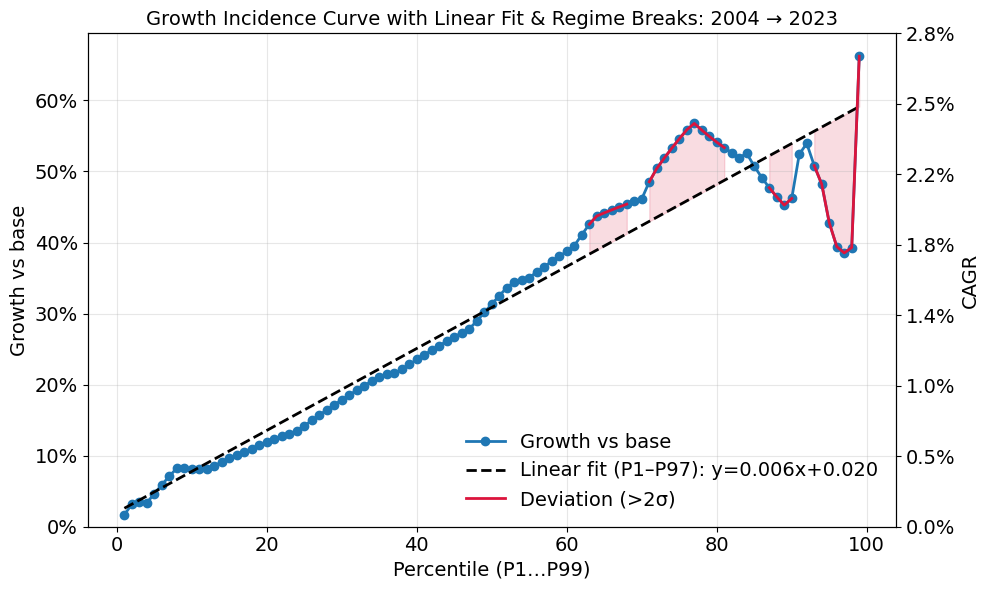

Detected deviation segments (> 2.0σ):
  P63–P68  (mean residual = +0.044)
  P71–P81  (mean residual = +0.077)
  P87–P90  (mean residual = -0.067)
  P93–P99  (mean residual = -0.109)


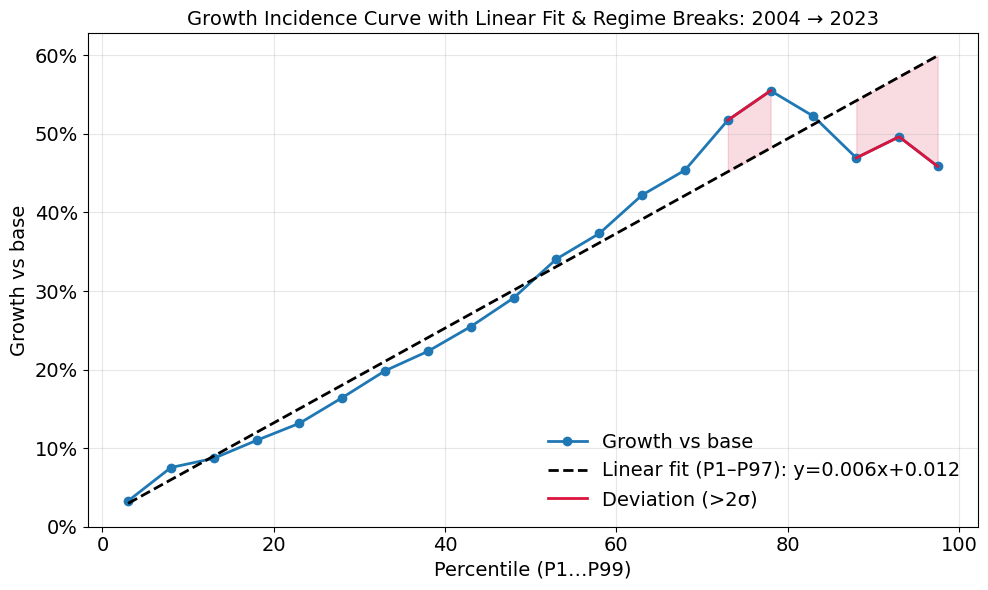

Detected deviation segments (> 2.0σ):
  P73–P78  (mean residual = +0.069)
  P88–P98  (mean residual = -0.097)


{'data':     percentile    growth      CAGR
 0        0.030  0.032869  0.001704
 1        0.080  0.075364  0.003831
 2        0.130  0.087038  0.004402
 3        0.180  0.109932  0.005505
 4        0.230  0.131638  0.006530
 5        0.280  0.164299  0.008038
 6        0.330  0.198534  0.009577
 7        0.380  0.223326  0.010666
 8        0.430  0.254767  0.012016
 9        0.480  0.291217  0.013543
 10       0.530  0.340803  0.015555
 11       0.580  0.373249  0.016834
 12       0.630  0.422198  0.018710
 13       0.680  0.453816  0.019890
 14       0.730  0.517411  0.022190
 15       0.780  0.554987  0.023507
 16       0.830  0.522425  0.022368
 17       0.880  0.469454  0.020464
 18       0.930  0.496333  0.021438
 19       0.975  0.458666  0.020068,
 'coef': array([0.00603008, 0.01159096]),
 'segments': [(14, 15), (17, 19)],
 'residuals': array([ 0.00318814,  0.01553225, -0.00294366, -0.01020009, -0.01864444,
        -0.01613378, -0.01205005, -0.0174077 , -0.01611765, -0.0098174 ,

In [32]:
# -------------------------------
# 5) Example usage
# -------------------------------
# Assumes you already have 'gic' with columns 'percentile' in [0,1] and 'growth' fractional.

# A) Original granularity (1 percentile)
plot_gic_with_breaks(gic, start_year=2004, end_year=2023, bin_size=1, save_prefix="sg_gic_with_fit_breaks", show_cagr_axis=True)

# B) Pooled into 5-percentile bins
plot_gic_with_breaks(gic, start_year=2004, end_year=2023, bin_size=5, save_prefix="sg_gic_with_fit_breaks")